## NLP Class Final Project Read Data
#### Naibo Hu

I am looking for your help understanding what would be the key factors for a successful data science or AI project.

The objective of your final project is to identify the underlying reasons for successes and failures in data science initiatives by extracting meaningful insights from unstructured text. Your goal is to provide actionable recommendations on what can be done to increase the success rates of these data science capabilities. 



To complete your assignment, I suggest considering the following steps:
- Clean-up the noise, by eliminating newlines, tabs, remnants of web crawls, and other irrelevant text
- Discard irrelevant articles
- Detect major topics
- Identify top reasons for failing data science initiatives (negative sentiment) - these can be related to technology, people,  data availability, etc.
- Suggest corrective actions
- Plot a timeline to illustrate how the sentiment is changing over time
- Demonstrate what companies, academic institutions and government entities can do to improve the outcomes of data science initiatives (positive sentiment)
- Leverage appropriate NLP techniques to identify organizations, people and locations, then apply targeted sentiment
- Why businesses should invest in data science initiatives (success stories)?
- Create appropriate visualization to summarize your recommendations (i.e. word cloud chart or bubble chart)
- What types of mistakes business can avoid in data science space (failures)?
- Create appropriate visualization to summarize your recommendations (i.e. word cloud chart or bubble chart)


# NLP Final Project Part II: Detect Major Topics (LDA)
Naibo Hu

In [1]:
import pandas as pd
import re
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import time
import math
from pprint import pprint
from textblob import TextBlob
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt


import nltk as nltk
from nltk.corpus import stopwords
import spacy
spacy.load("en_core_web_sm")
import multiprocessing
import string


import gensim
from gensim import corpora, models
from gensim.models.ldamulticore import LdaMulticore
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

In [3]:
%%time

df_news_final_project = pd.read_parquet('https://storage.googleapis.com/msca-bdp-data-open/news_final_project/news_final_project.parquet', engine='pyarrow')
df_news_final_project.shape

CPU times: total: 6.56 s
Wall time: 29.9 s


(199538, 5)

In [4]:
df_news_final_project.head()

,url,date,language,title,text
0,http://blog.executivebiz.com/2017/02/sap-ns2s-...,2017-02-07,en,SAP NS2’s Mark Testoni: AI Could Help Prevent ...,\nSAP NS2’s Mark Testoni: AI Could Help Preve...
1,http://bq-magazine.com/a-decade-of-advancement...,2019-12-31,en,A Decade Of Advancements As We Enter A New Age...,\n\nA Decade Of Advancements As We Enter A New...
2,http://businessnewsthisweek.com/business/gende...,2022-03-09,en,Gender Bias in Artificial Intelligence | Busin...,\nGender Bias in Artificial Intelligence | Bus...
3,http://cn.reuters.com/article/pharmaceuticals-...,2017-07-04,en,Big pharma turns to AI to speed drug discovery...,\n\nBig pharma turns to AI to speed drug disco...
4,http://fortune.com/2018/03/13/ai-computer-amaz...,2018-03-13,en,"Amazon HQ2 Winner May Be Boston, Says Wells Fa...","\n\nAmazon HQ2 Winner May Be Boston, Says Well..."


In [5]:
df = df_news_final_project

In [6]:
pd.set_option('display.max_colwidth', None)

## Data Cleaning

#### Clean-up the noise, by eliminating newlines, tabs, remnants of web crawls, and other irrelevant text

In [7]:
df["clean_text"] = df["text"].apply(lambda x: re.sub(r'\n', '',x)) # remove new line
df["clean_text"] = df["clean_text"].apply(lambda x: re.sub(r'https://.*', '',x)) # remove url
df["clean_text"] = df["clean_text"].apply(lambda x: re.sub(r'@\w*', '',x)) # remove mention
df["clean_text"] = df["clean_text"].apply(lambda x: re.sub(r'#\w*', '',x)) # remove tag
# keep only letters, periods, and white space
df["clean_text"] = df["clean_text"].apply(lambda x: re.sub(r'[^a-zA-Z.\s]', '',x))
# change consecutive white space into 1 whitespace
df["clean_text"] = df["clean_text"].apply(lambda x: re.sub(' +', ' ',x))

In [8]:
 # remove remnants of web crawls
df["clean_text"] = df["clean_text"].apply(lambda x: re.sub(r'\xa0SAP', '',x))
df["clean_text"] = df["clean_text"].apply(lambda x: re.sub(r'\xa0National', '',x))
df["clean_text"] = df["clean_text"].apply(lambda x: re.sub(r'\xa0', '',x))
df["clean_text"] = df["clean_text"].apply(lambda x: re.sub(r'\t', '',x))

#### Discard irrelevant articles

In [9]:
keywords = ['AI', 'ai', 'artifical intelligence','Artificial Intelligence','ARTIFICIAL INTELLIGENCE', 'Data Science', 'data science', 'DATA SCIENCE']
query = '|'.join(keywords)

In [10]:
df_clean = df[df['clean_text'].str.contains(query)]

In [11]:
df_clean.shape

(198545, 6)

#### Drop Duplicates

In [16]:
df_clean[["date","title", "clean_text"]].drop_duplicates().shape

(194679, 3)

In [19]:
df_clean = df_clean[["title", "clean_text"]].drop_duplicates()

In [20]:
df_clean.shape

(193864, 2)

In [21]:
# export clean text to csv
df_clean.to_csv("clean_text.csv", index = False)

In [4]:
df_clean = pd.read_csv("clean_text.csv")

In [6]:
df = df_clean

## Detect major topics

### LDA on all articles

In [8]:
# Tokenize text into words and remove punctuation
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
        
        
data_list = df['clean_text'].tolist()        
data_tokens = list(sent_to_words(data_list))

In [9]:
bigram = gensim.models.Phrases(data_tokens, min_count=1, threshold=1)
trigram = gensim.models.Phrases(bigram[data_tokens], threshold=1)

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [10]:
stop_words = stopwords.words('english')

# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [11]:
%%time
# Remove Stop Words
data_tokens_nostops = remove_stopwords(data_tokens)

# Create n-grams
data_words_bigrams = make_bigrams(data_tokens_nostops)
data_words_trigrams = make_trigrams(data_tokens_nostops)

# Combine tokens and n-grams
# data_tokens_cobnined = data_tokens_nostops + data_words_bigrams + data_words_trigrams
data_tokens_cobnined = data_words_trigrams

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

# Lemmatize text keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_tokens_cobnined, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

#print(*data_lemmatized[:1])

CPU times: total: 1h 36min 52s
Wall time: 1h 46min 32s


In [12]:
# Creating the term diction                       ary of our courpus, where every unique term is assigned an index. 
dictionary = corpora.Dictionary(data_lemmatized)

# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
doc_term_matrix = [dictionary.doc2bow(doc) for doc in data_lemmatized]

In [13]:
#Build initial 3 topic model
num_processors = multiprocessing.cpu_count()
workers = num_processors-1

lda_model = LdaMulticore(corpus=doc_term_matrix,
                   id2word=dictionary,
                   num_topics=3,
                   random_state=100,
                   passes=10,
                   alpha='symmetric',
                   eta='auto',
                   workers=workers)

In [14]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.35808400307943683


In [15]:
# Tune LDA model
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = LdaMulticore(corpus=doc_term_matrix,
                       id2word=dictionary,
                       num_topics=k,
                       random_state=100,                  
                       passes=10,
                       alpha=a,
                       eta=b,
                       workers=workers)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=dictionary, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [16]:
grid = {}
grid['Validation_Set'] = {}
# Topics range
min_topics = 2
max_topics = 10
step_size = 1
topics_range = range(min_topics, max_topics+1, step_size)

# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')


# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')


# Validation sets
num_of_docs = len(doc_term_matrix)
corpus_sets = [doc_term_matrix]
corpus_title = ['100% Corpus']
model_results = {
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }

itr = 0
itr_total = len(beta)*len(alpha)*len(topics_range)*len(corpus_title)
print(f'LDA will execute {itr_total} iterations')

    
# iterate through hyperparameters
for i in range(len(corpus_sets)):
    # iterate through number of topics
    for k in topics_range:
        # iterate through alpha values
        
        for a in alpha:
            # iterare through beta values
            for b in beta:
                # get the coherence score for the given parameters
                itr += 1
                cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=dictionary, 
                                              k=k, a=a, b=b)
                # Save the model results
                model_results['Topics'].append(k)
                model_results['Alpha'].append(a)
                model_results['Beta'].append(b)
                model_results['Coherence'].append(cv)
                pct_completed = round((itr / itr_total * 100),1)
#                 print(f'Completed Percent: {pct_completed}%, Corpus: {corpus_title[i]}, Topics: {k}, Alpha: {a}, Beta: {b}, Coherence: {cv}')
        print(f'Completed model based on {k} LDA topics. Finished {pct_completed}% of LDA runs')
        
                     
lda_tuning = pd.DataFrame(model_results)


LDA will execute 270 iterations
Completed model based on 2 LDA topics. Finished 11.1% of LDA runs
Completed model based on 3 LDA topics. Finished 22.2% of LDA runs
Completed model based on 4 LDA topics. Finished 33.3% of LDA runs
Completed model based on 5 LDA topics. Finished 44.4% of LDA runs
Completed model based on 6 LDA topics. Finished 55.6% of LDA runs
Completed model based on 7 LDA topics. Finished 66.7% of LDA runs
Completed model based on 8 LDA topics. Finished 77.8% of LDA runs
Completed model based on 9 LDA topics. Finished 88.9% of LDA runs
Completed model based on 10 LDA topics. Finished 100.0% of LDA runs


In [18]:
lda_tuning.to_csv("lda_article_text_all.csv")

In [19]:
lda_tuning.sort_values(by=['Coherence'], ascending=False).head(10)

,Topics,Alpha,Beta,Coherence
183,8,0.01,0.91,0.506472
198,8,0.91,0.91,0.504507
223,9,0.61,0.91,0.497020
263,10,symmetric,0.91,0.486851
243,10,0.01,0.91,0.484490
178,7,asymmetric,0.91,0.469683
268,10,asymmetric,0.91,0.467886
228,9,0.91,0.91,0.462129
258,10,0.91,0.91,0.458198
193,8,0.61,0.91,0.457577


<AxesSubplot:title={'center':'Overall LDA Tuning'}, xlabel='Topics'>

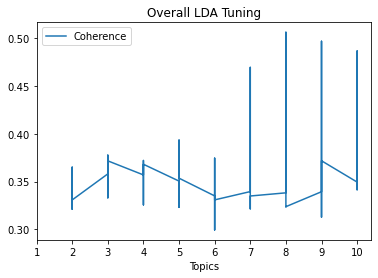

In [20]:
lda_tuning.plot(x ='Topics', y='Coherence', title = 'Overall LDA Tuning',kind = 'line', xticks=range(1,11))

In [21]:
lda_tuning_best = lda_tuning.sort_values(by=['Coherence'], ascending=False).head(1)


tuned_topics = int(lda_tuning_best['Topics'].to_string(index=False))


# Since the values for Alpha and Beta can be float, symmetric and asymmetric, we will either strip or convert to float
try:
    tuned_alpha = float(lda_tuning_best['Alpha'].to_string(index=False))
except:
    tuned_alpha = lda_tuning_best['Alpha'].to_string(index=False).strip()
    

try:
    tuned_beta = float(lda_tuning_best['Beta'].to_string(index=False))
except:
    tuned_beta = lda_tuning_best['Beta'].to_string(index=False).strip()    
    
print(f'Best Parameters: Topics: {tuned_topics}, Alpha: {tuned_alpha}, Beta: {tuned_beta}')

Best Parameters: Topics: 8, Alpha: 0.01, Beta: 0.91


### Print best model - 8 topics

In [22]:
lda_model_8 = LdaMulticore(corpus=doc_term_matrix,
                   id2word=dictionary,
                   num_topics=8,
                   random_state=100,
                   passes=10,
                   alpha='symmetric',
                   eta='auto',
                   workers=workers)

In [24]:
# Print the Keyword in the 8 topics
print(*lda_model_8.print_topics(num_topics=8, num_words=10), sep='\n')

(0, '0.007*"say" + 0.005*"show" + 0.004*"new" + 0.004*"make" + 0.003*"reveal" + 0.003*"use" + 0.003*"ai" + 0.003*"take" + 0.003*"day" + 0.003*"year"')
(1, '0.013*"trade" + 0.009*"dollar" + 0.008*"ai" + 0.005*"use" + 0.005*"company" + 0.004*"share" + 0.003*"technology" + 0.003*"stock" + 0.002*"exchange" + 0.002*"high"')
(2, '0.009*"say" + 0.006*"company" + 0.005*"use" + 0.005*"ai" + 0.003*"technology" + 0.003*"new" + 0.003*"rights_reserve" + 0.002*"year" + 0.002*"make" + 0.002*"work"')
(3, '0.014*"ai" + 0.008*"use" + 0.006*"say" + 0.005*"make" + 0.005*"work" + 0.004*"technology" + 0.004*"need" + 0.003*"get" + 0.003*"time" + 0.003*"datum"')
(4, '0.009*"ai" + 0.003*"say" + 0.003*"technology" + 0.003*"use" + 0.002*"make" + 0.002*"company" + 0.002*"work" + 0.002*"datum" + 0.002*"world" + 0.002*"power"')
(5, '0.012*"ai" + 0.007*"technology" + 0.007*"company" + 0.005*"use" + 0.005*"business" + 0.005*"datum" + 0.004*"customer" + 0.004*"solution" + 0.004*"service" + 0.003*"platform"')
(6, '0.00

In [25]:
lda_display = gensimvis.prepare(lda_model_8, doc_term_matrix, dictionary, sort_topics=False, mds='mmds')
pyLDAvis.display(lda_display)